In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-q6oft_6b because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_closure():
    plt.show()
    plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [4]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 154 pickup attempts
std of:  0.17447834259676462
shape before reducing dimension (154, 64, 8)
dataset variance of: [0.00197013 0.0012774  0.00135245 0.00687806 0.0256     0.00588592
 0.00669464]


In [5]:
dataset = start_points
dataset

array([[ 0.03644411, -0.05664173, -0.01726175, ...,  0.05311595,
         0.03802196,  0.04693789],
       [-0.07453766, -0.01680912, -0.0215112 , ..., -0.05982878,
        -0.04222452, -0.07548245],
       [ 0.00971311, -0.02070482, -0.03210563, ...,  0.05624359,
         0.00829467,  0.04349922],
       ...,
       [-0.01814567,  0.012406  , -0.01415396, ..., -0.08273447,
        -0.04929883,  0.05353723],
       [-0.0386492 ,  0.02261964,  0.00349406, ..., -0.24490761,
        -0.07656989,  0.03259478],
       [ 0.01510075, -0.00209672, -0.00561974, ...,  0.21811145,
         0.10821248,  0.05325818]])

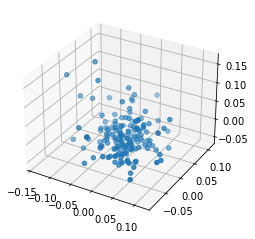

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);

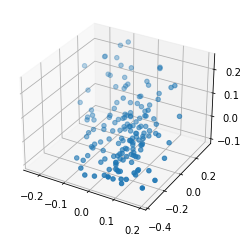

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
testname = "pedagogicallgsweep/sweep"

In [12]:
all_models = []
for lr in [0.01,0.001,0.0005,0.0001]:
    for beta in [0.0001,0.01,1]:
        for curvreg in [0,0.1,0.001,0.01]:#,1,10,100,1000]:
            secreg = 0
            for latentdim in [2]:
                for epsilon_scale_start in [0.1]:
                    try:
                        savedir_pattern  = f'{testname}lat{latentdim}_lr{lr}_curvreg{curvreg}_beta{beta}_*'
                        filename = glob.glob(savedir_pattern)[0]
                        textfilename = glob.glob(savedir_pattern + "/model_type.txt")[0]
                        all_models.append(filename)
                    except:
                        continue

In [13]:
all_models

['pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217',
 'pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405',
 'pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407',
 'pedagogica

In [14]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [15]:
def make_2d_grid_points(xmin, xmax, ymin, ymax, ):
    #lim = 6
    num_few = 7
    num_many = 100
    pts = []
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_many):
                pts.append((x,y))
    for y in np.linspace(ymin, ymax, num_few):
        for x in np.linspace(xmin, xmax, num_many):
                pts.append((x,y))
    return np.array(pts)

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955
(154, 2)


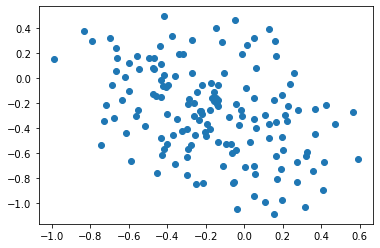

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701
(154, 2)


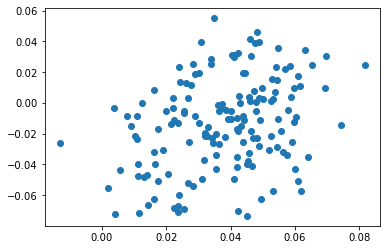

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850
(154, 2)


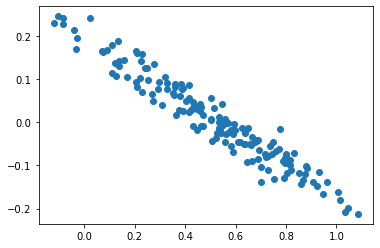

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038
(154, 2)


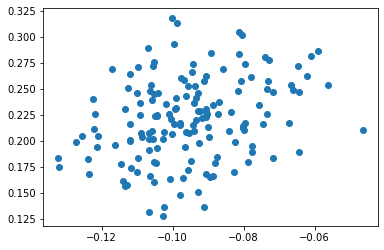

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226
(154, 2)


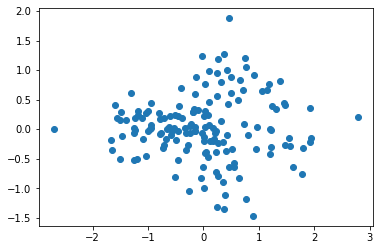

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345
(154, 2)


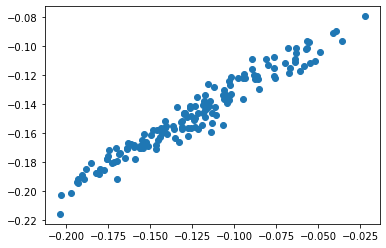

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533
(154, 2)


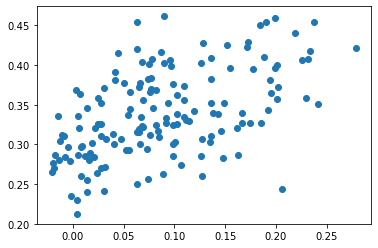

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721
(154, 2)


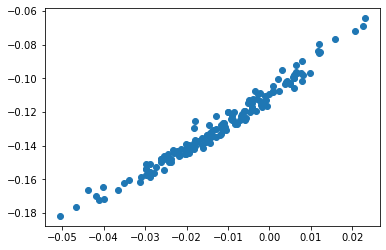

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829
(154, 2)


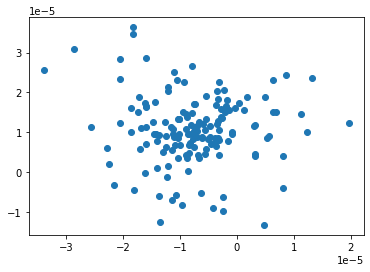

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029
(154, 2)


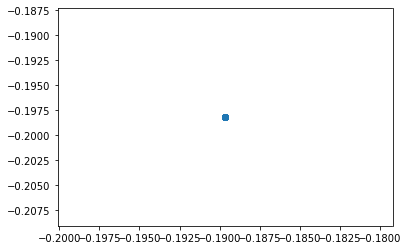

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217
(154, 2)


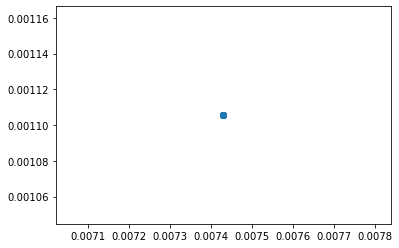

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405
(154, 2)


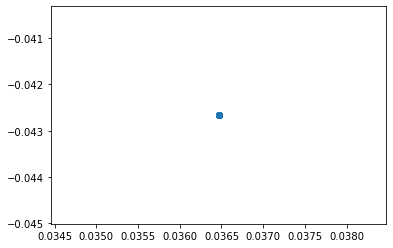

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407
(154, 2)


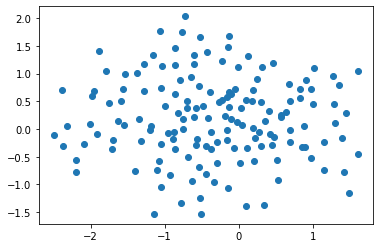

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.0001_20220207-164713
(154, 2)


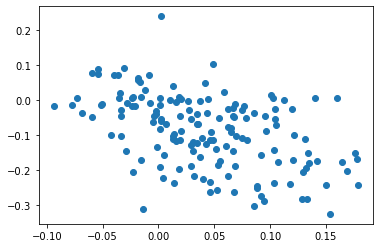

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.0001_20220207-164901
(154, 2)


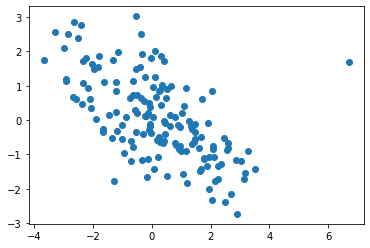

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.0001_20220207-165049
(154, 2)


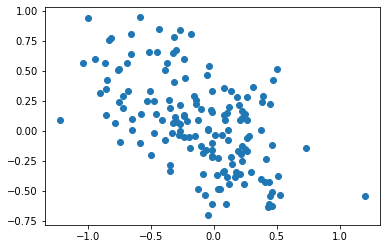

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.01_20220207-165237
(154, 2)


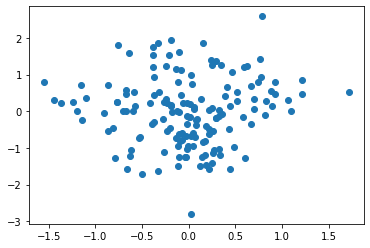

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.01_20220207-165356
(154, 2)


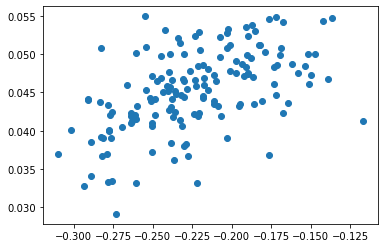

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.01_20220207-165544
(154, 2)


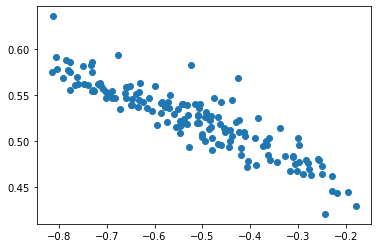

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.01_20220207-165733
(154, 2)


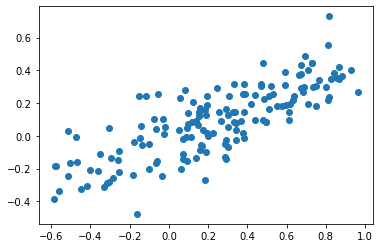

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta1_20220207-151241
(154, 2)


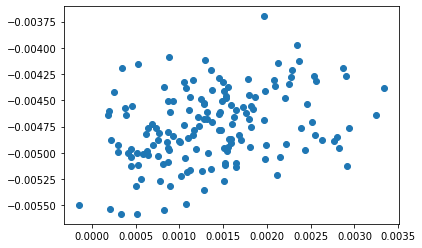

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta1_20220207-170040
(154, 2)


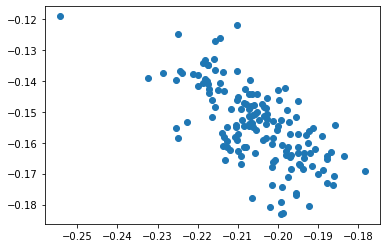

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta1_20220207-170229
(154, 2)


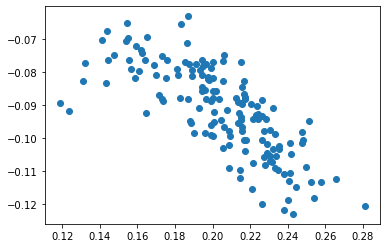

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta1_20220207-170418
(154, 2)


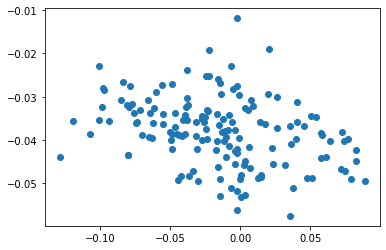

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.0001_20220207-153820
(154, 2)


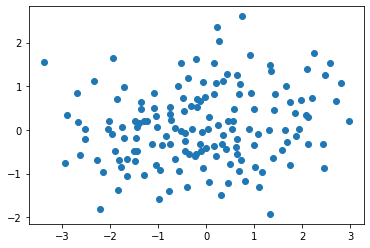

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.0001_20220207-170725
(154, 2)


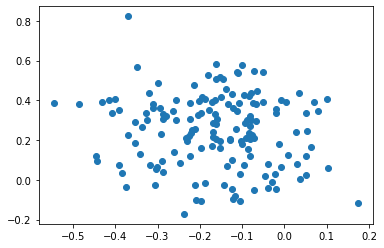

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.0001_20220207-170914
(154, 2)


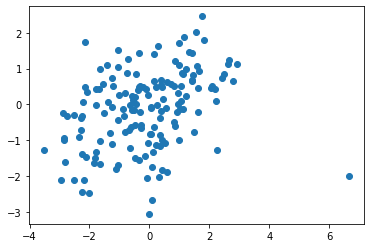

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.0001_20220207-171103
(154, 2)


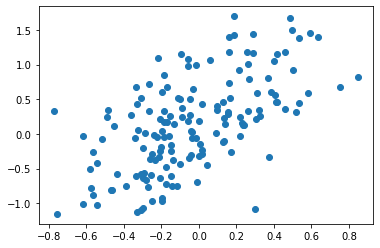

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.01_20220207-171251
(154, 2)


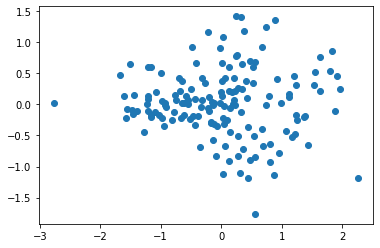

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.01_20220207-171409
(154, 2)


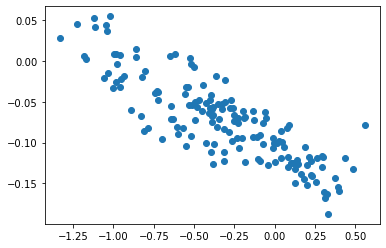

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.01_20220207-171558
(154, 2)


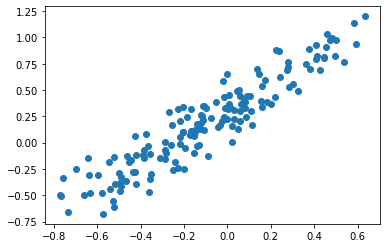

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.01_20220207-171746
(154, 2)


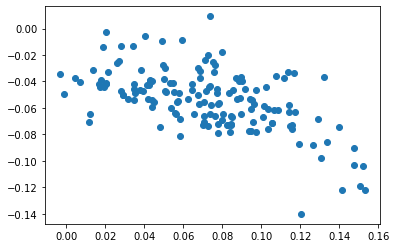

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta1_20220207-154653
(154, 2)


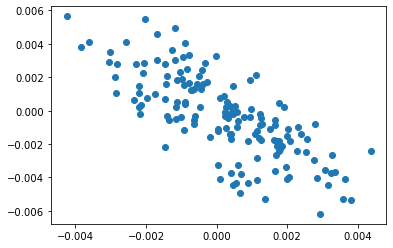

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta1_20220207-172053
(154, 2)


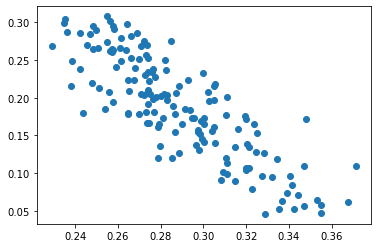

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta1_20220207-172242
(154, 2)


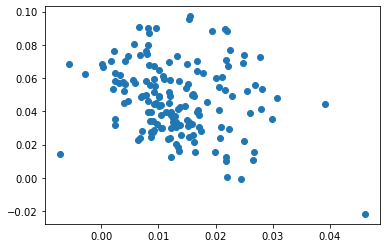

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta1_20220207-172431
(154, 2)


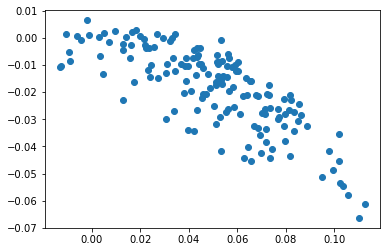

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.0001_20220207-161304
(154, 2)


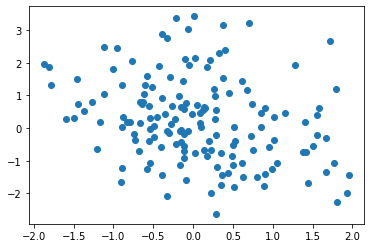

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.0001_20220207-172739
(154, 2)


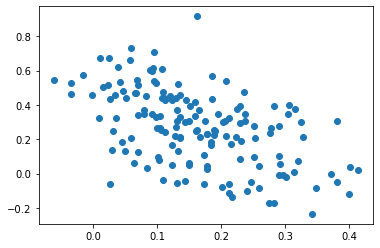

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.0001_20220207-172928
(154, 2)


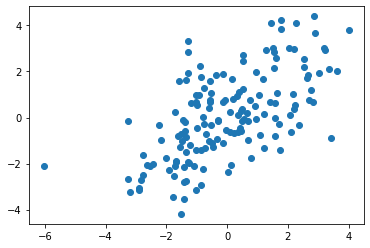

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.0001_20220207-173117
(154, 2)


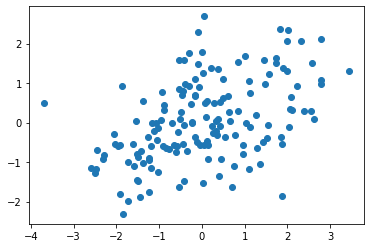

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.01_20220207-173306
(154, 2)


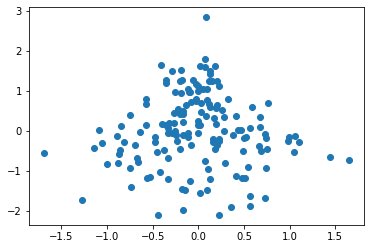

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.01_20220207-173425
(154, 2)


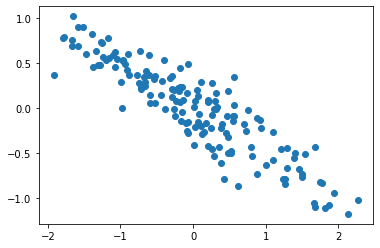

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.01_20220207-173613
(154, 2)


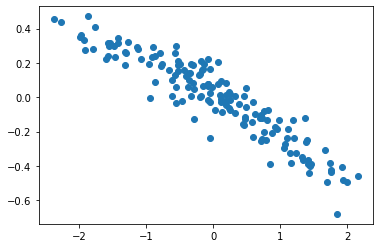

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.01_20220207-173802
(154, 2)


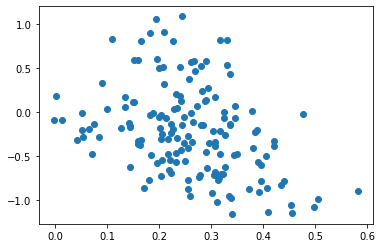

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta1_20220207-162208
(154, 2)


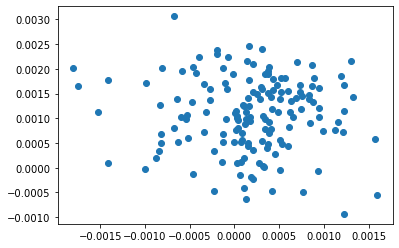

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta1_20220207-174110
(154, 2)


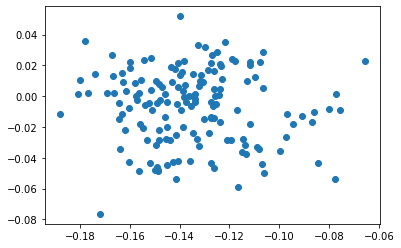

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta1_20220207-174300
(154, 2)


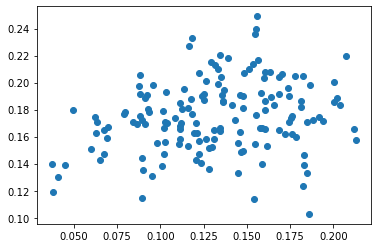

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta1_20220207-174448
(154, 2)


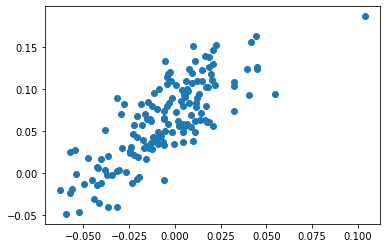

In [16]:
for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    print(embeds.shape)
    plt.scatter(embeds[:,0],embeds[:,1]);
    plot_closure()

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955


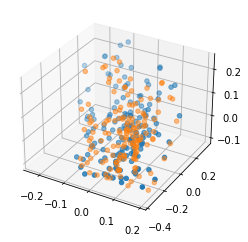

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701


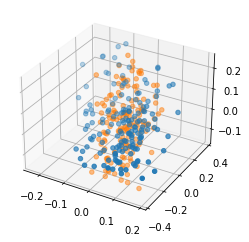

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850


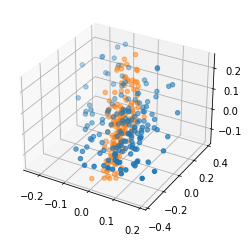

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038


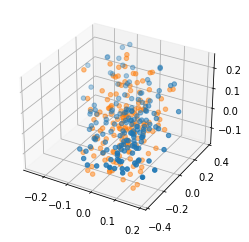

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226


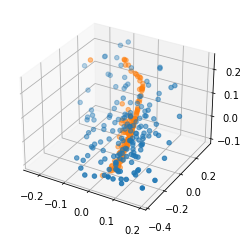

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345


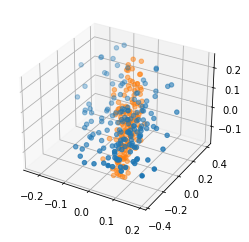

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533


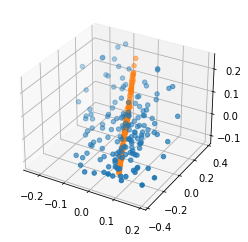

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721


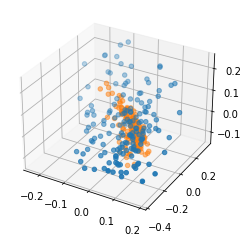

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829


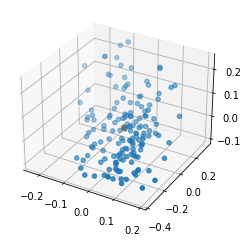

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029


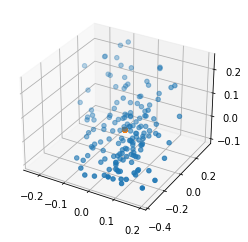

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217


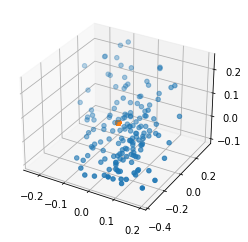

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405


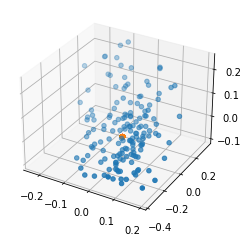

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407


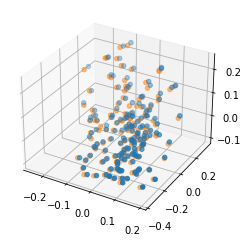

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.0001_20220207-164713


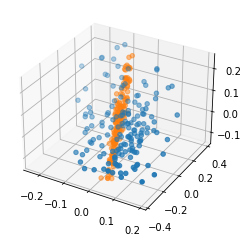

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.0001_20220207-164901


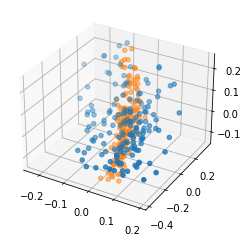

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.0001_20220207-165049


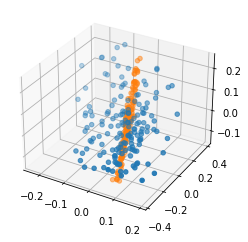

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.01_20220207-165237


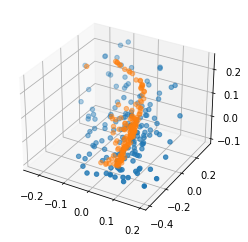

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.01_20220207-165356


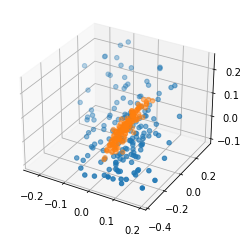

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.01_20220207-165544


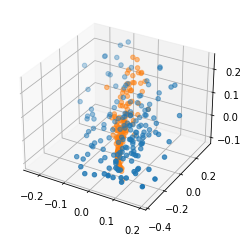

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.01_20220207-165733


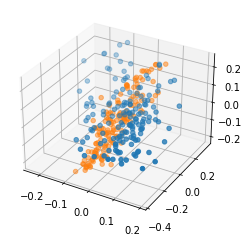

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta1_20220207-151241


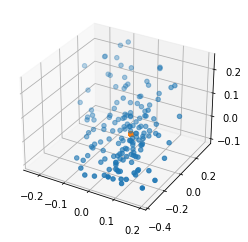

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta1_20220207-170040


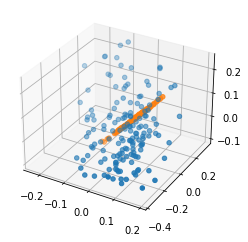

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta1_20220207-170229


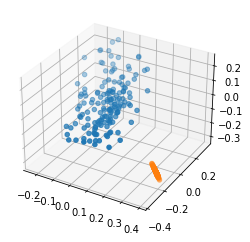

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta1_20220207-170418


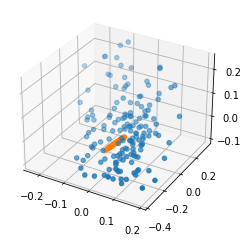

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.0001_20220207-153820


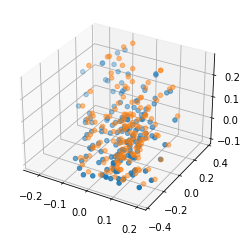

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.0001_20220207-170725


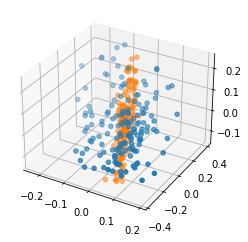

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.0001_20220207-170914


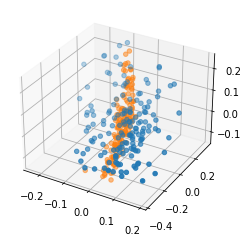

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.0001_20220207-171103


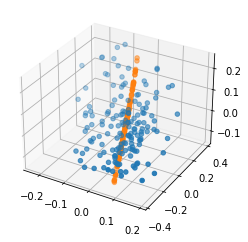

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.01_20220207-171251


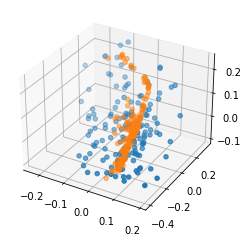

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.01_20220207-171409


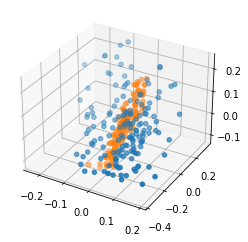

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.01_20220207-171558


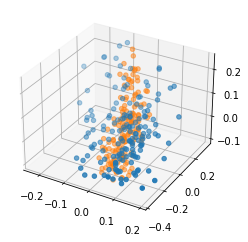

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.01_20220207-171746


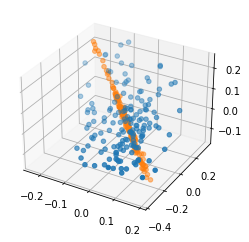

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta1_20220207-154653


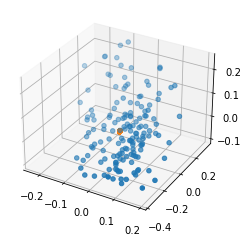

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta1_20220207-172053


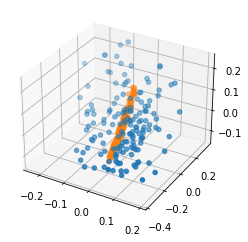

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta1_20220207-172242


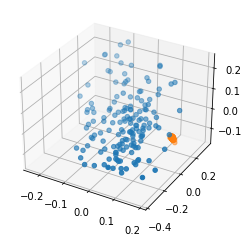

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta1_20220207-172431


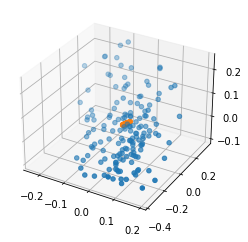

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.0001_20220207-161304


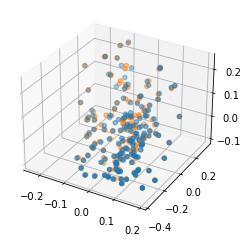

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.0001_20220207-172739


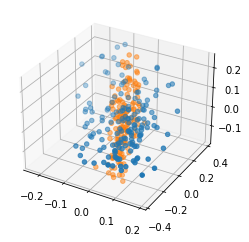

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.0001_20220207-172928


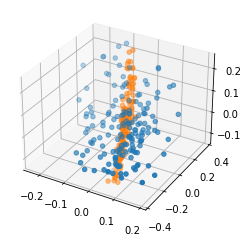

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.0001_20220207-173117


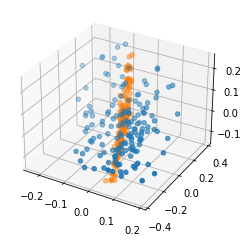

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.01_20220207-173306


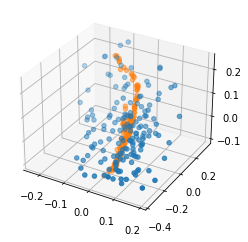

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.01_20220207-173425


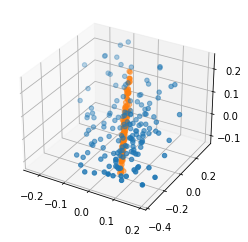

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.01_20220207-173613


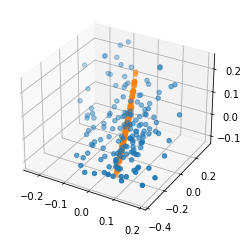

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.01_20220207-173802


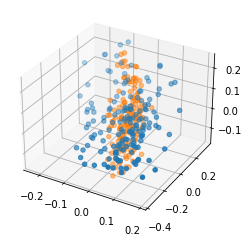

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta1_20220207-162208


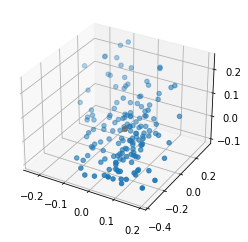

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta1_20220207-174110


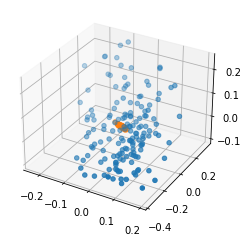

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta1_20220207-174300


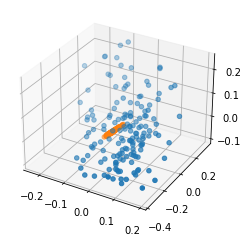

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta1_20220207-174448


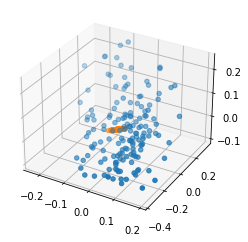

In [17]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0]
    readout = vae.decode(embeds,
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);
    ax.scatter(readout[:,3],readout[:,4],readout[:,5], alpha=0.5);
    plot_closure()

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955


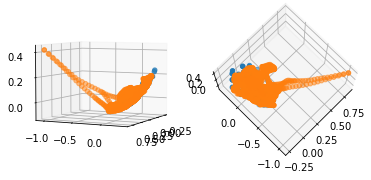

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701


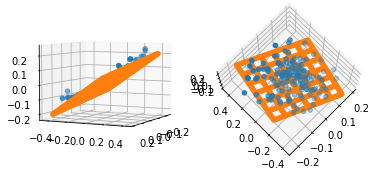

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850


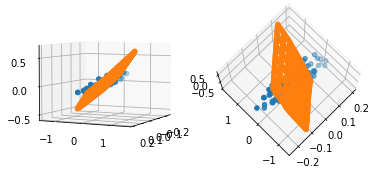

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038


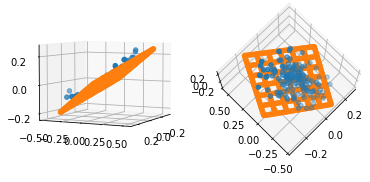

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226


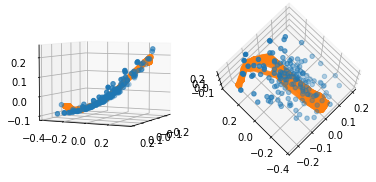

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345


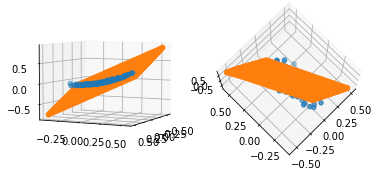

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533


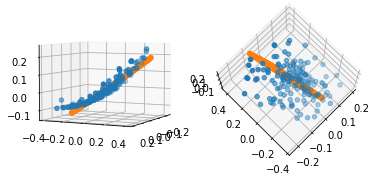

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721


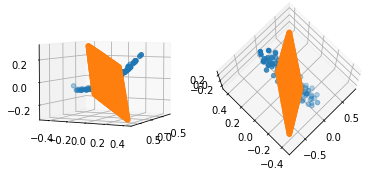

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829


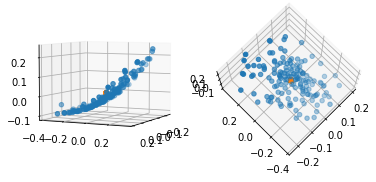

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029


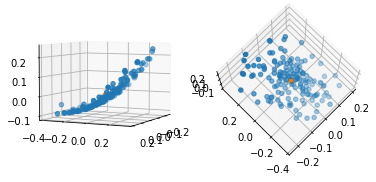

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217


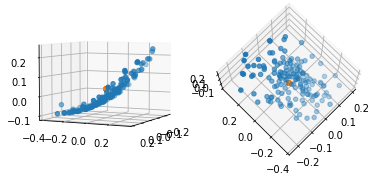

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405


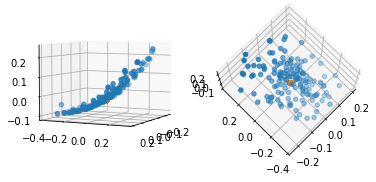

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407


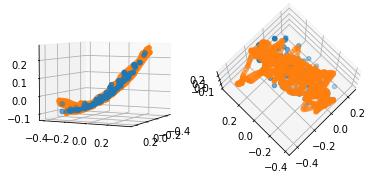

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.0001_20220207-164713


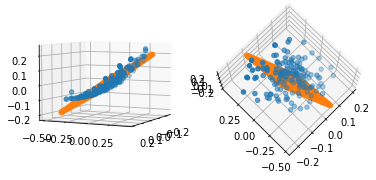

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.0001_20220207-164901


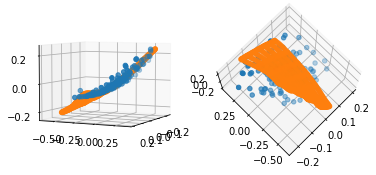

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.0001_20220207-165049


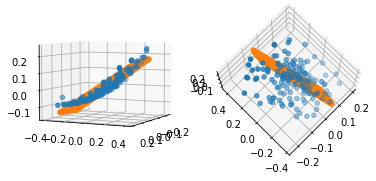

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.01_20220207-165237


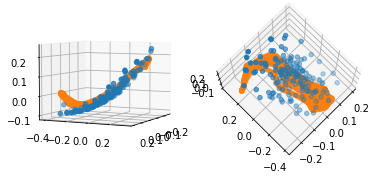

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.01_20220207-165356


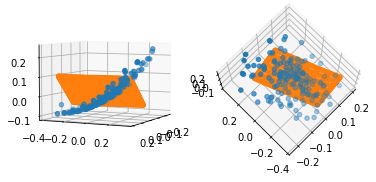

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.01_20220207-165544


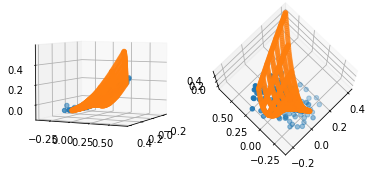

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.01_20220207-165733


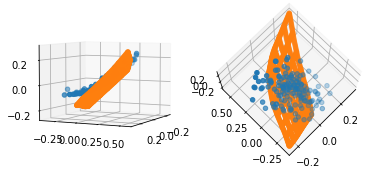

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta1_20220207-151241


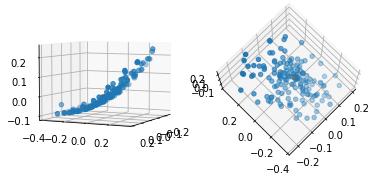

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta1_20220207-170040


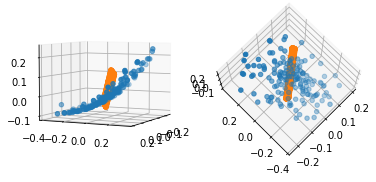

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta1_20220207-170229


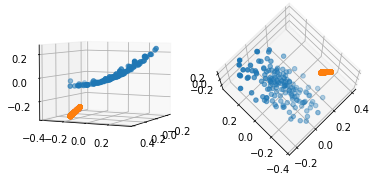

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta1_20220207-170418


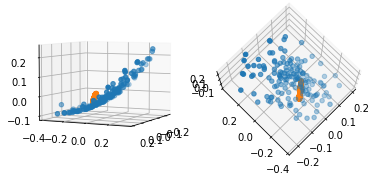

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.0001_20220207-153820


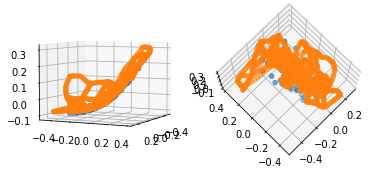

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.0001_20220207-170725


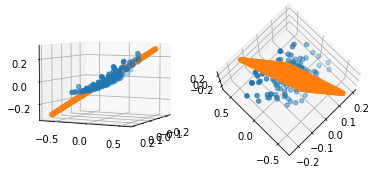

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.0001_20220207-170914


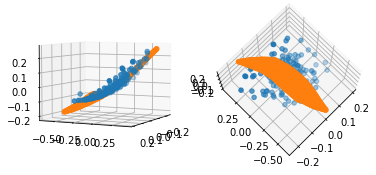

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.0001_20220207-171103


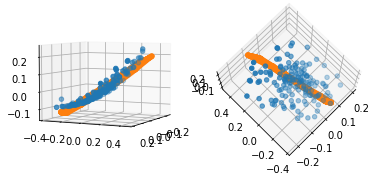

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.01_20220207-171251


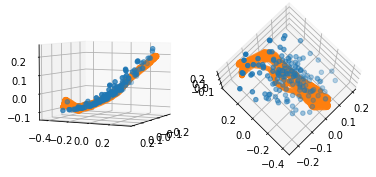

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.01_20220207-171409


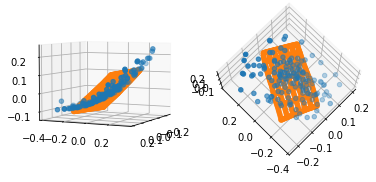

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.01_20220207-171558


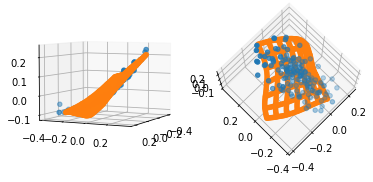

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.01_20220207-171746


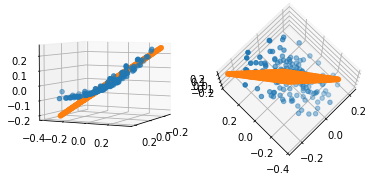

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta1_20220207-154653


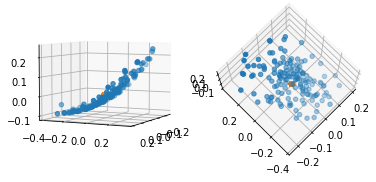

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta1_20220207-172053


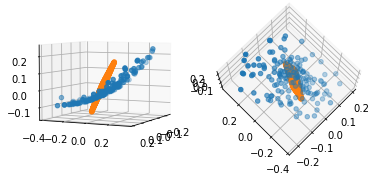

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta1_20220207-172242


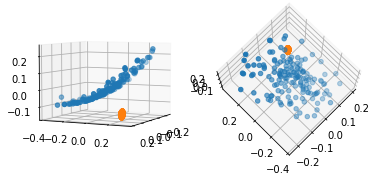

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta1_20220207-172431


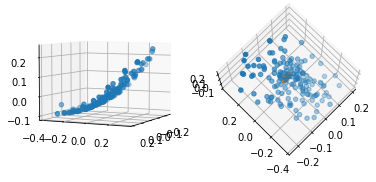

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.0001_20220207-161304


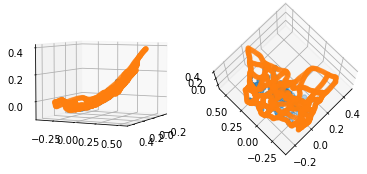

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.0001_20220207-172739


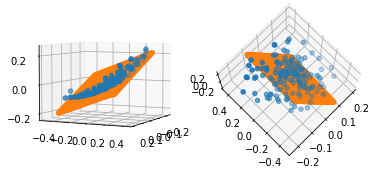

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.0001_20220207-172928


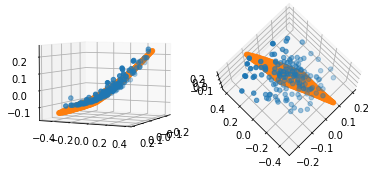

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.0001_20220207-173117


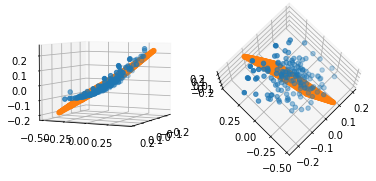

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.01_20220207-173306


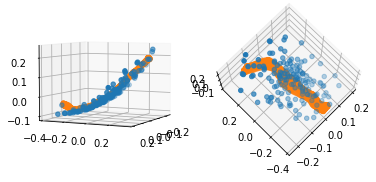

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.01_20220207-173425


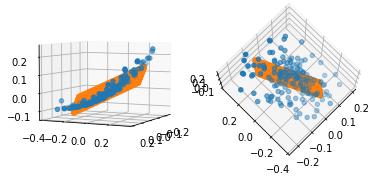

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.01_20220207-173613


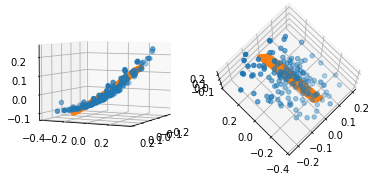

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.01_20220207-173802


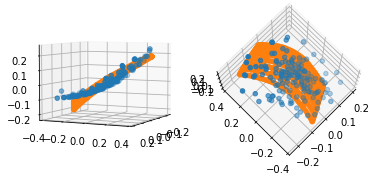

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta1_20220207-162208


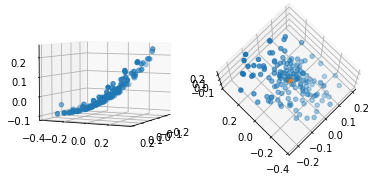

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta1_20220207-174110


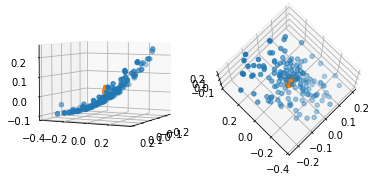

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta1_20220207-174300


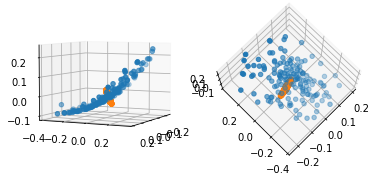

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta1_20220207-174448


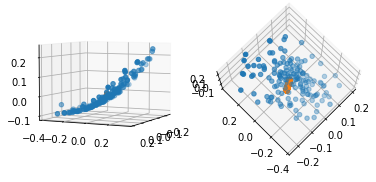

In [18]:
for i, modelpath in enumerate(all_models):
    f, axs = plt.subplots(1,2,subplot_kw={'projection':'3d'})
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    for ax in axs:
        ax.scatter(dataset[:,3],dataset[:,4],dataset[:,5]);
        ax.scatter(readout[:,3],readout[:,4],readout[:,5], alpha=0.5);
    axs[0].view_init(elev=5., azim=26)
    axs[1].view_init(elev=76., azim=-135)
    plot_closure()

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955


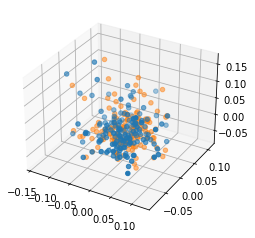

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701


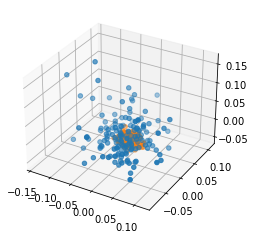

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850


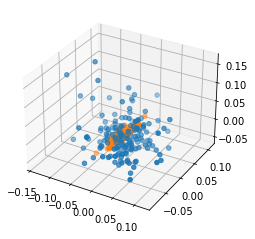

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038


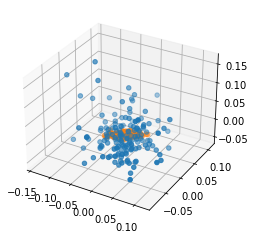

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226


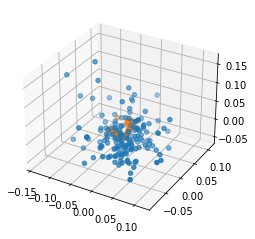

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345


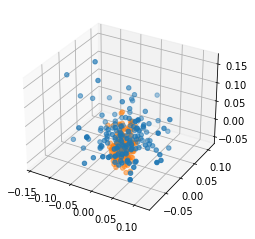

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533


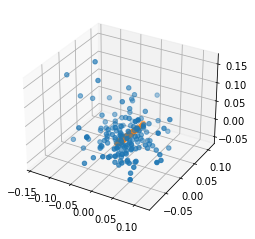

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721


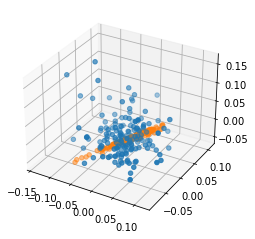

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829


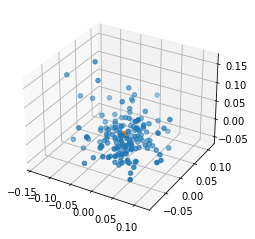

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029


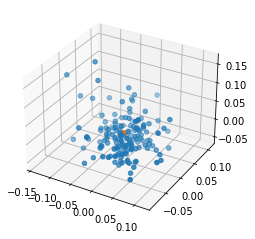

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217


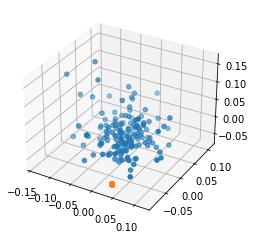

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405


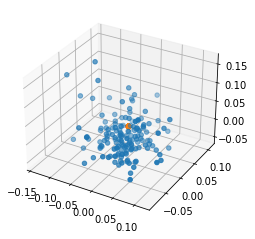

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407


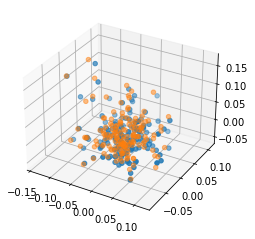

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.0001_20220207-164713


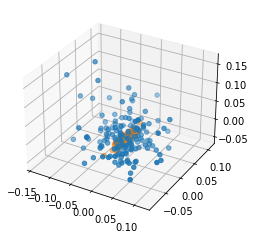

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.0001_20220207-164901


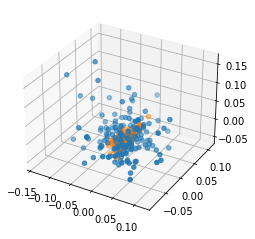

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.0001_20220207-165049


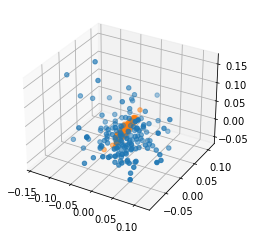

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.01_20220207-165237


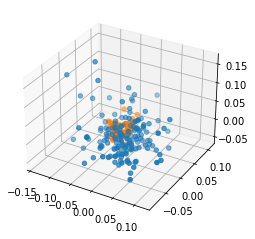

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.01_20220207-165356


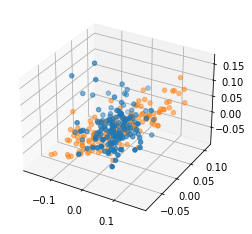

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.01_20220207-165544


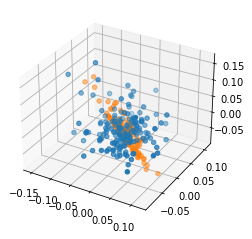

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.01_20220207-165733


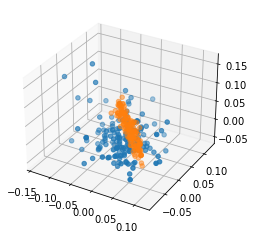

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta1_20220207-151241


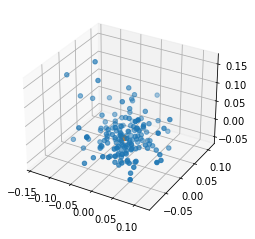

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta1_20220207-170040


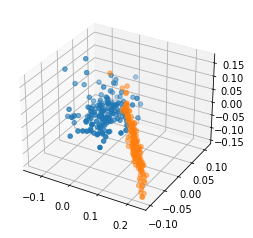

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta1_20220207-170229


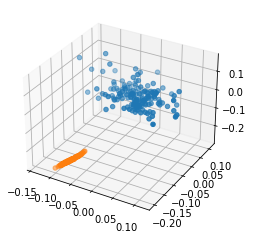

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta1_20220207-170418


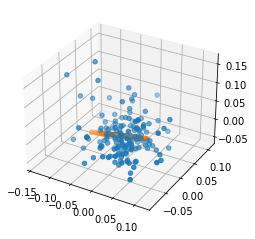

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.0001_20220207-153820


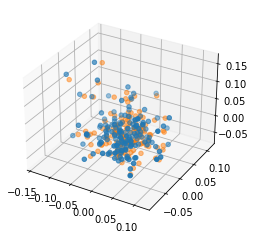

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.0001_20220207-170725


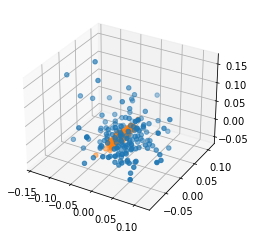

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.0001_20220207-170914


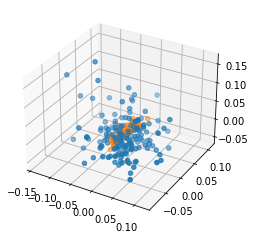

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.0001_20220207-171103


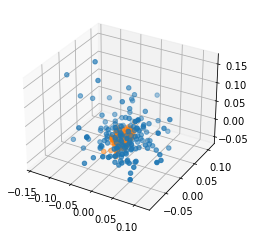

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.01_20220207-171251


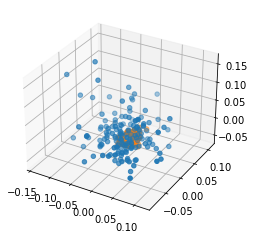

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.01_20220207-171409


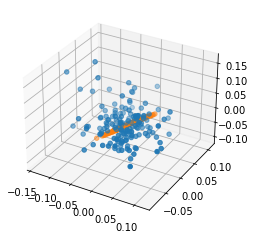

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.01_20220207-171558


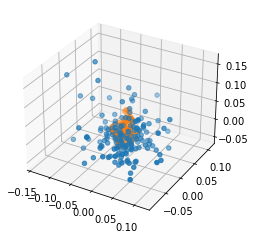

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.01_20220207-171746


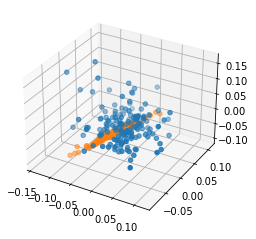

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta1_20220207-154653


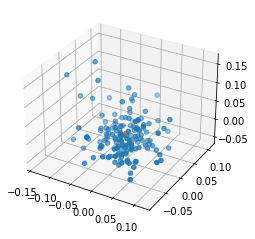

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta1_20220207-172053


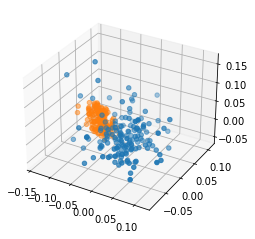

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta1_20220207-172242


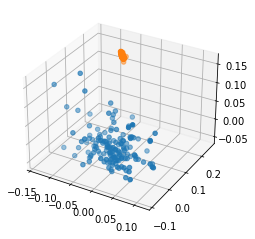

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta1_20220207-172431


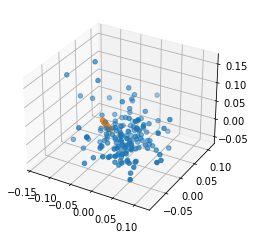

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.0001_20220207-161304


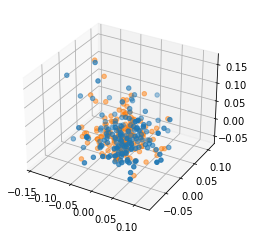

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.0001_20220207-172739


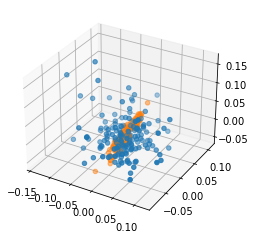

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.0001_20220207-172928


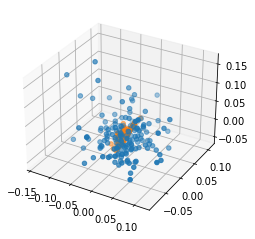

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.0001_20220207-173117


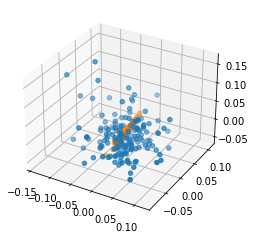

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.01_20220207-173306


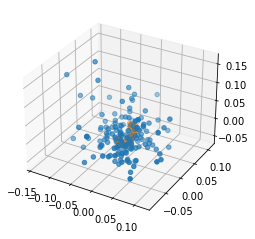

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.01_20220207-173425


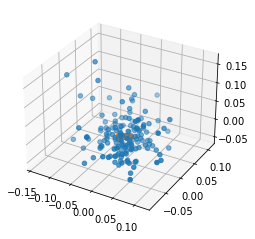

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.01_20220207-173613


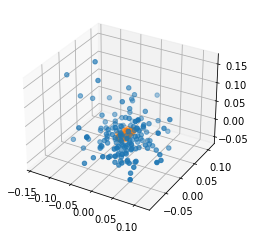

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.01_20220207-173802


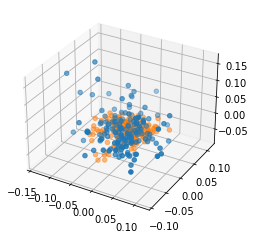

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta1_20220207-162208


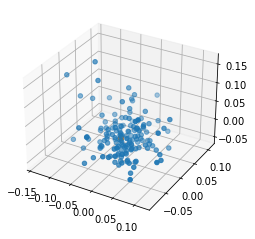

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta1_20220207-174110


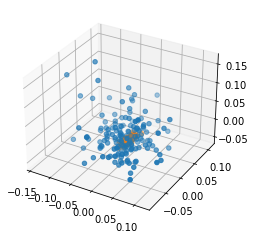

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta1_20220207-174300


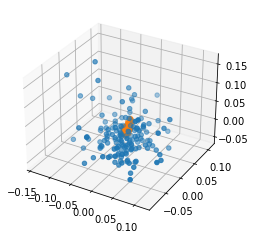

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta1_20220207-174448


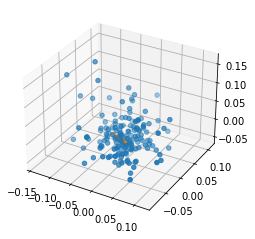

In [19]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0]
    readout = vae.decode(embeds,
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);
    plot_closure()

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.0001_20220207-142955


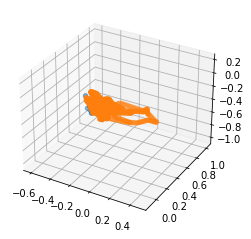

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.0001_20220207-162701


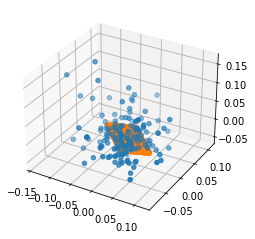

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.0001_20220207-162850


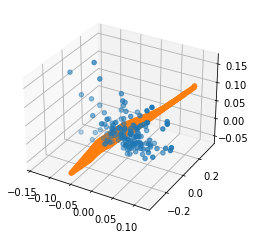

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.0001_20220207-163038


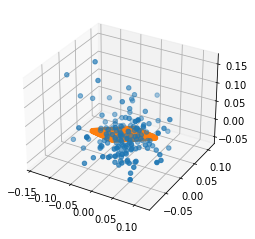

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta0.01_20220207-163226


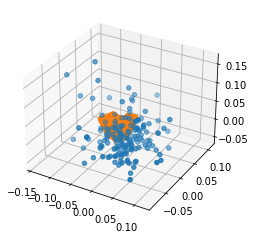

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta0.01_20220207-163345


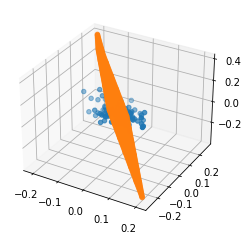

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta0.01_20220207-163533


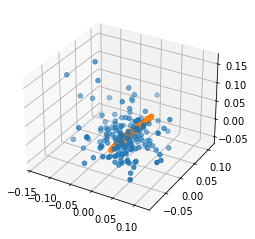

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta0.01_20220207-163721


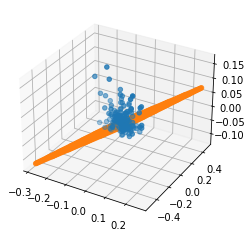

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0_beta1_20220207-143829


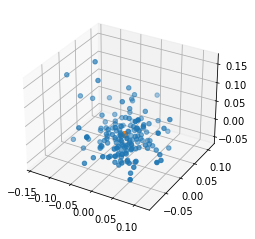

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.1_beta1_20220207-164029


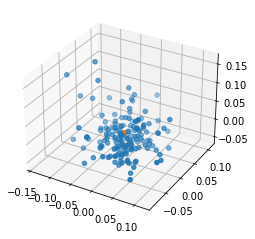

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.001_beta1_20220207-164217


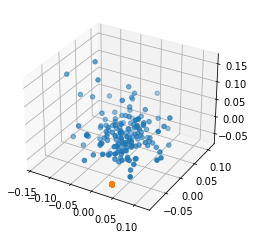

pedagogicallgsweep/sweeplat2_lr0.01_curvreg0.01_beta1_20220207-164405


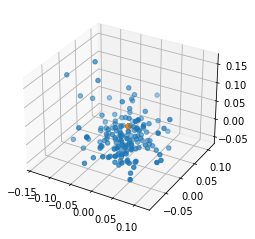

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.0001_20220207-150407


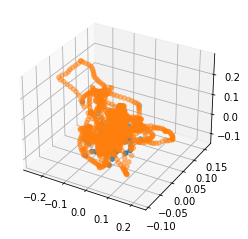

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.0001_20220207-164713


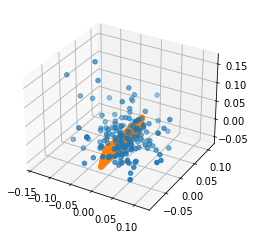

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.0001_20220207-164901


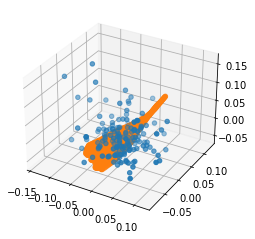

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.0001_20220207-165049


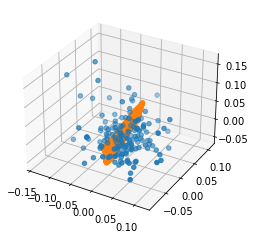

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta0.01_20220207-165237


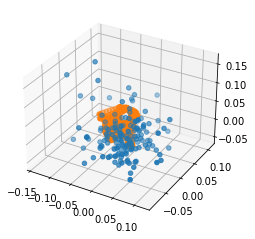

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta0.01_20220207-165356


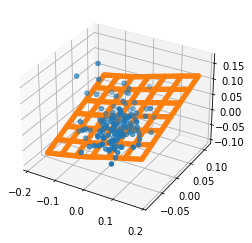

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta0.01_20220207-165544


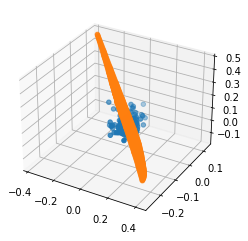

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta0.01_20220207-165733


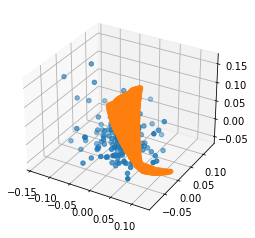

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0_beta1_20220207-151241


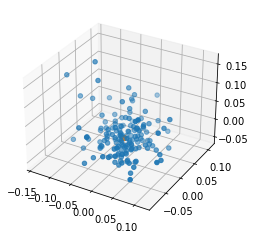

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.1_beta1_20220207-170040


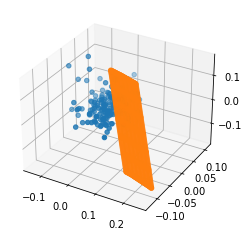

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.001_beta1_20220207-170229


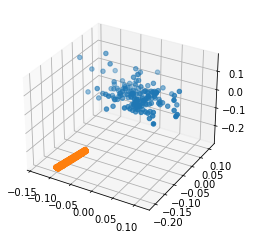

pedagogicallgsweep/sweeplat2_lr0.001_curvreg0.01_beta1_20220207-170418


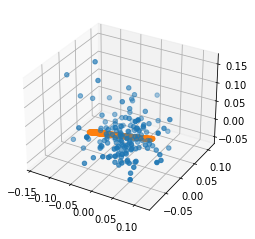

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.0001_20220207-153820


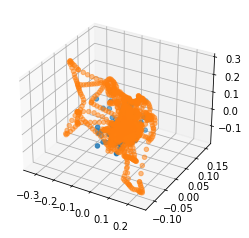

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.0001_20220207-170725


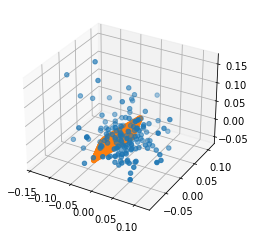

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.0001_20220207-170914


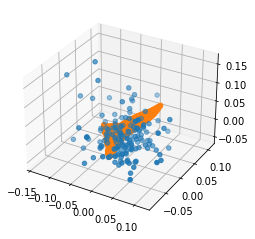

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.0001_20220207-171103


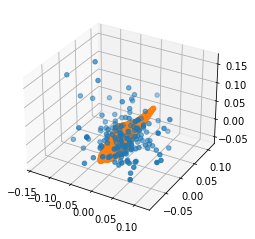

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta0.01_20220207-171251


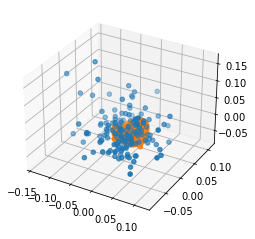

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta0.01_20220207-171409


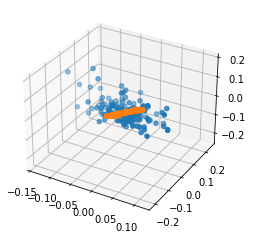

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta0.01_20220207-171558


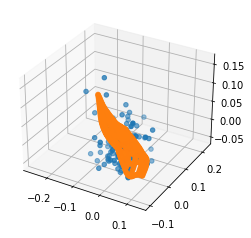

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta0.01_20220207-171746


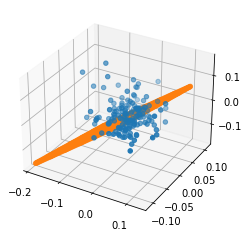

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0_beta1_20220207-154653


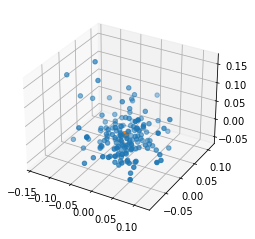

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.1_beta1_20220207-172053


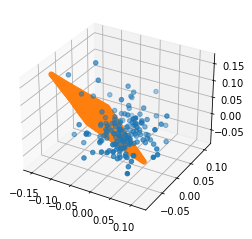

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.001_beta1_20220207-172242


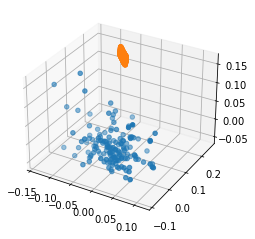

pedagogicallgsweep/sweeplat2_lr0.0005_curvreg0.01_beta1_20220207-172431


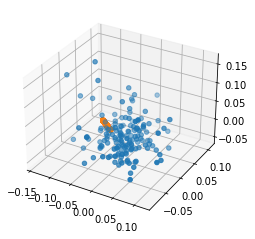

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.0001_20220207-161304


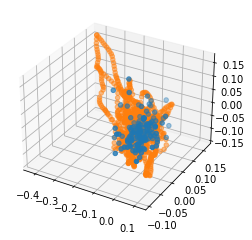

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.0001_20220207-172739


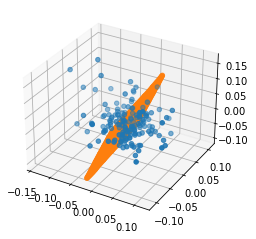

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.0001_20220207-172928


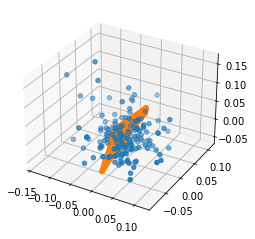

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.0001_20220207-173117


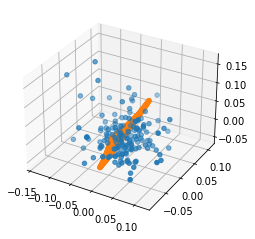

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta0.01_20220207-173306


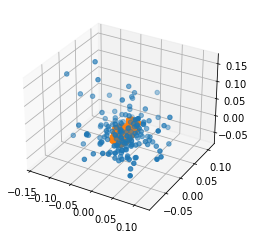

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta0.01_20220207-173425


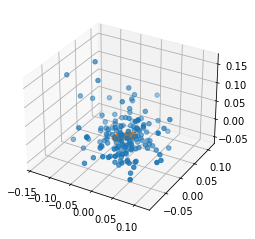

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta0.01_20220207-173613


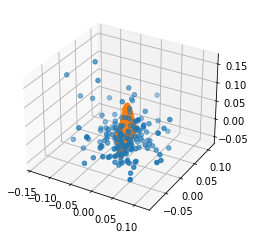

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta0.01_20220207-173802


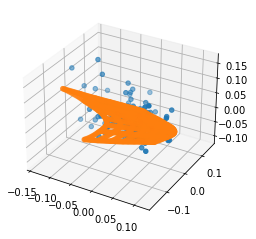

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0_beta1_20220207-162208


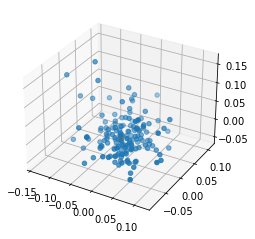

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.1_beta1_20220207-174110


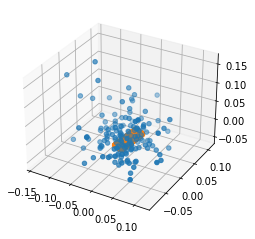

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.001_beta1_20220207-174300


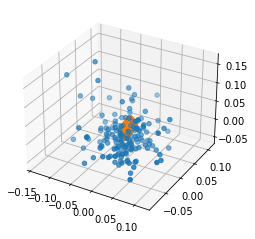

pedagogicallgsweep/sweeplat2_lr0.0001_curvreg0.01_beta1_20220207-174448


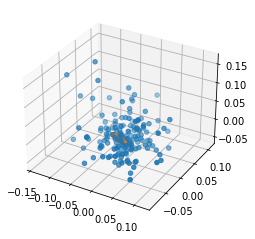

In [20]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);
    plot_closure()